In [15]:
import numpy as np
from numpy.typing import NDArray

import scipy.stats as st

from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from mapie.metrics.regression import regression_coverage_score
from mapie.regression import SplitConformalRegressor
from mapie.utils import train_conformalize_test_split

from tqdm import tqdm

import reliable_conformal_prediction as rcp

N_MC_SIMULATIONS = 10000

NOM_COV = 0.9 # Deisred coverage level
CONF = 0.95

CAL_SIZE = 100
TRAIN_SIZE = 1000
TEST_SIZE = 10000
N= CAL_SIZE + TRAIN_SIZE + TEST_SIZE

SIGMA = 0.1

In [16]:
pol_feat = PolynomialFeatures(degree=4)

def f(x: NDArray) -> NDArray:
    """Polynomial function used to generate one-dimensional data."""
    return np.array(5 * x + 5 * x**4 - 9 * x**2)

In [17]:
def get_data(random_state:int):
    """
    Generate synthetic data for regression with noise.

    Parameters
    ----------
    random_state : int
        Seed for the random number generator.

    Returns
    -------
    X_train : NDArray
        Training features.
    y_train : NDArray
        Training targets.
    X_cal : NDArray
        Calibration features.
    y_cal : NDArray
        Calibration targets.
    X_test : NDArray
        Test features.
    y_test : NDArray
        Test targets.
    """
    rng = np.random.default_rng(random_state)
    X = np.linspace(0, 1, N)
    y = f(X) + rng.normal(0, SIGMA, N)
    y = f(X) + rng.normal(0, SIGMA, N)
    X = X.reshape(-1, 1)
    (X_train, X_cal, X_test, y_train, y_cal, y_test) = (
        train_conformalize_test_split(
            X,
            y,
            train_size=TRAIN_SIZE,
            conformalize_size=CAL_SIZE,
            test_size=TEST_SIZE,
            random_state=random_state,
        )
    )

    return X_train, y_train, X_cal, y_cal, X_test, y_test

def get_conformalized_models(random_state:int, X_train:NDArray, y_train:NDArray, X_cal:NDArray, y_cal:NDArray):
    """
    Generate conformalized models using classic and reliable conformal prediction.

    Parameters
    ----------
    random_state : int
        Seed for the random number generator.
    X_train : NDArray
        Training features.
    y_train : NDArray
        Training targets.
    X_cal : NDArray
        Calibration features.
    y_cal : NDArray
        Calibration targets.

    Returns
    -------
    mapie_classic_regressor : SplitConformalRegressor
        MAPIE regressor using classic conformal prediction.
    mapie_reliable_regressor : SplitConformalRegressor
        MAPIE regressor using reliable conformal prediction.
    """
    rng = np.random.default_rng(random_state)

    regressor = LinearRegression()
    regressor.fit(pol_feat.fit_transform(X_train), y_train)

    # MAPIE regressor using classic conformal prediction
    mapie_classic_regressor = SplitConformalRegressor(
        estimator=regressor, confidence_level=NOM_COV, prefit=True
    )
    mapie_classic_regressor.conformalize(pol_feat.transform(X_cal), y_cal)


    # MAPIE regressor using reliable conformal prediction
    corrected_coverage = rcp.classic_conf_pred_wrapper(n=X_cal.shape[0], min_cov=NOM_COV, conf=CONF)
    mapie_reliable_regressor = SplitConformalRegressor(
        estimator=regressor, confidence_level=corrected_coverage, prefit=True
    )
    mapie_reliable_regressor.conformalize(pol_feat.transform(X_cal), y_cal)

    return mapie_classic_regressor, mapie_reliable_regressor

def compute_coverage(mapie_regressor, X_test:NDArray, y_test:NDArray) -> float:
    """
    Compute the coverage score of a MAPIE regressor on test data.

    Parameters
    ----------
    mapie_regressor : SplitConformalRegressor
        A MAPIE regressor object.
    X_test : NDArray
        Test features.
    y_test : NDArray
        Test targets.

    Returns
    -------
    coverage_score : float
        The coverage score of the prediction intervals.
    """
    y_pred, y_pred_interval = mapie_regressor.predict_interval(pol_feat.transform(X_test))
    coverage_score = regression_coverage_score(y_test, y_pred_interval)

    return coverage_score

In [18]:
# Monte Carlo simulation to evaluate the coverage of classic and reliable conformal prediction using MAPIE regressors

classic_cov_dist = []
reliable_cov_dist = []

for i in tqdm(range(N_MC_SIMULATIONS)):
    X_train, y_train, X_cal, y_cal, X_test, y_test = get_data(random_state=i) # Generate the data
    mapie_classic_regressor, mapie_reliable_regressor = get_conformalized_models(random_state=i, X_train=X_train, y_train=y_train, X_cal=X_cal, y_cal=y_cal) # Train and conformalize the models

    # Compute the coverages of this Monte Carlo realization
    classic_cov_score = compute_coverage(mapie_classic_regressor, X_test, y_test) 
    reliable_cov_score = compute_coverage(mapie_reliable_regressor, X_test, y_test)

    classic_cov_dist.append(classic_cov_score)
    reliable_cov_dist.append(reliable_cov_score)

classic_cov_dist = np.array(classic_cov_dist).squeeze()
reliable_cov_dist = np.array(reliable_cov_dist).squeeze()

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [01:24<00:00, 118.84it/s]


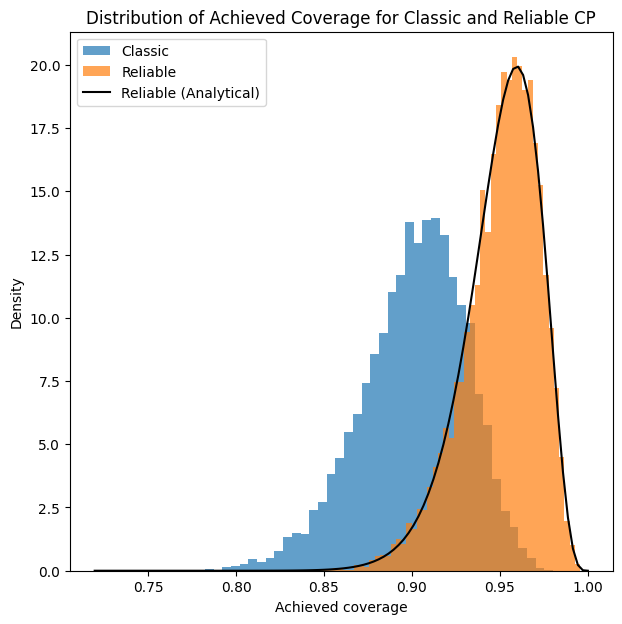

In [19]:
fig, axs = plt.subplots(figsize=(7,7))

axs.hist(np.array(classic_cov_dist).flatten(), bins=50, alpha=0.7, label='Classic', density=True)
axs.hist(np.array(reliable_cov_dist).flatten(), bins=50, alpha=0.7, label='Reliable', density=True)

# Plot the analytical coverage distribution
xlim = axs.get_xlim()
x_space = np.linspace(xlim[0], 1.0, 100)
q_ncp = rcp.get_quantile(CAL_SIZE, NOM_COV, CONF) # Quantile level for reliable conformal prediction
m = np.ceil(q_ncp*(CAL_SIZE))
cov_dist = st.beta(m, CAL_SIZE-m+1)
axs.plot(x_space, cov_dist.pdf(x_space), color="k", label="Reliable (Analytical)")

axs.set_xlabel("Achieved coverage")
axs.set_ylabel("Density")
axs.set_title("Distribution of Achieved Coverage for Classic and Reliable CP")

axs.legend()
plt.show()

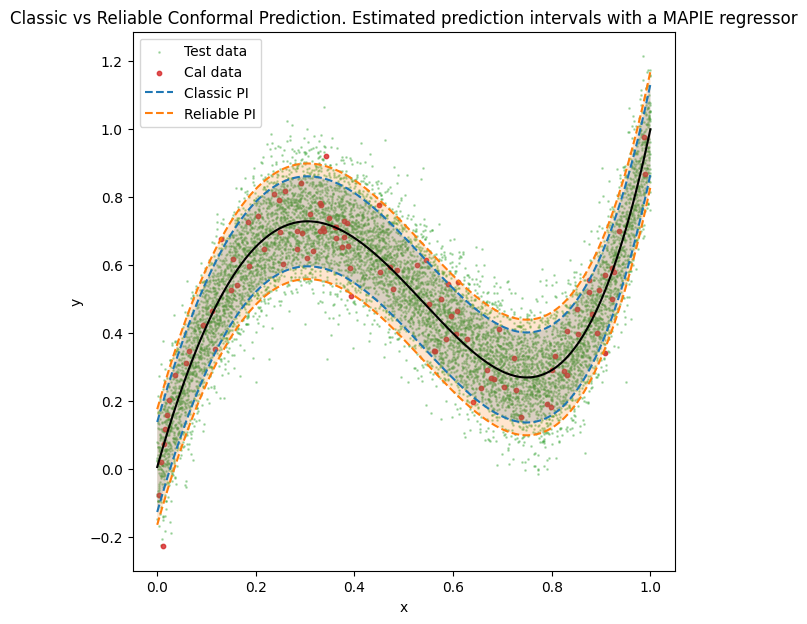

In [20]:
# Plot one of the Monte Carlo realizations

X_train, y_train, X_cal, y_cal, X_test, y_test = get_data(random_state=0)
mapie_classic_regressor, mapie_reliable_regressor = get_conformalized_models(random_state=0, X_train=X_train, y_train=y_train, X_cal=X_cal, y_cal=y_cal)

y_pred, y_pred_interval_classic = mapie_classic_regressor.predict_interval(pol_feat.transform(X_test))
_, y_pred_interval_reliable = mapie_reliable_regressor.predict_interval(pol_feat.transform(X_test))

fig, axs = plt.subplots(figsize=(7,7))

axs.set_xlabel("x")
axs.set_ylabel("y")
axs.scatter(X_test, y_test, alpha=0.3, color="C2", s=1, label="Test data")
axs.scatter(X_cal, y_cal, alpha=0.8, color="C3", s=10, label="Cal data")

X_test = X_test.ravel()
order = np.argsort(X_test)

axs.plot(X_test[order], y_pred[order], color="k")

axs.plot(X_test[order], y_pred_interval_classic[order][:, 0, 0], color="C0", ls="--", label="Classic PI")
axs.plot(X_test[order], y_pred_interval_classic[order][:, 1, 0], color="C0", ls="--")
axs.fill_between(
    X_test[order],
    y_pred_interval_classic[:, 0, 0][order].ravel(),
    y_pred_interval_classic[:, 1, 0][order].ravel(),
    alpha=0.2,
)

axs.plot(X_test[order], y_pred_interval_reliable[order][:, 0, 0], color="C1", ls="--", label="Reliable PI")
axs.plot(X_test[order], y_pred_interval_reliable[order][:, 1, 0], color="C1", ls="--")
axs.fill_between(
    X_test[order],
    y_pred_interval_reliable[:, 0, 0][order].ravel(),
    y_pred_interval_reliable[:, 1, 0][order].ravel(),
    alpha=0.2,
)

axs.legend()
axs.set_title("Classic vs Reliable Conformal Prediction. Estimated prediction intervals with a MAPIE regressor")
plt.show()
